In [1]:
clear all

In [2]:
import nibabel as nib
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askdirectory
import libtiff 
import matplotlib.pyplot as plt
%matplotlib inline

# Get folder

In [3]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/sophie/e14406b6-b6d1-4305-86e1-f0fe5128f521/100174ss1


In [4]:
path=foldername

In [5]:
A=foldername.split('/')
Dataname=A[-1]

In [6]:
Dataname

'100174ss1'

# Open the images

In [7]:
t = libtiff.TiffFile(path+'/'+Dataname+'-00383.tif') 
tt = t.get_tiff_array() 
t.close()
S=tt.shape
data=np.zeros([S[0],S[1],S[2],len(os.listdir(path))])
#for i in range(1,15000):
for i in range(len(os.listdir(path))):       
#for fn in os.listdir(path):
    t = libtiff.TiffFile(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    #t = libtiff.TiffFile(path+fn) 
    tt = t.get_tiff_array()
    data[:,:,:,i]=tt[:][:][:]
    t.close()
    #i=i+1

In [8]:
Dataname+'-'+str(i+1).zfill(5)+'.tif'

'100174ss1-05056.tif'

In [9]:
S=data.shape
S

(36, 105, 105, 5056)

In [10]:
3507+383

3890

# Find end of onset of light and begining of offset (to align to behavior) 

Calculate average time series

In [11]:
M=np.mean(np.mean(np.mean(data,0),0),0)
Mav=M.mean()

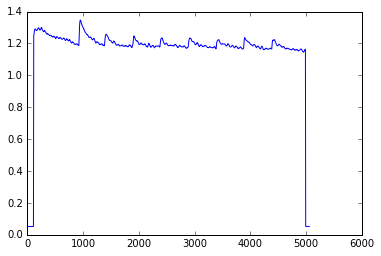

In [12]:
plt.plot(M)

Get approxiamte on and off times

In [13]:
liston=[i for i in range(len(M)) if M[i]>Mav*0.7]
liston[0]

114

Model for fitting onset and offset

In [14]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

Model onset and find precise onset time

In [15]:
Ms=M[range(liston[0]-8,liston[0]+8)]

In [16]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [17]:
liston[0]-8

106

In [18]:
res = scipy.optimize.minimize(Sq,x0=[7,0.3,9,0.7])

In [19]:
ON=liston[0]-8+res.x[2]
print(ON)

114.013566491


In [20]:
ONint=np.int(np.ceil(ON))
Onint=1
print(ONint)

115


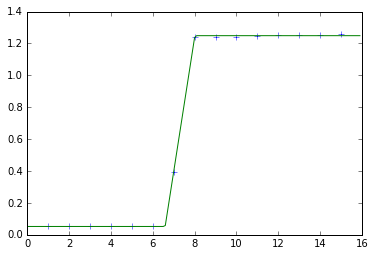

In [21]:
plt.plot(np.squeeze(M[range(liston[0]-8,liston[0]+8)]),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [22]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

In [23]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [24]:
res = scipy.optimize.minimize(Sq,x0=[7,3,9,-1])

In [25]:
OFF=liston[len(liston)-1]-8+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

4984.63984102
4984


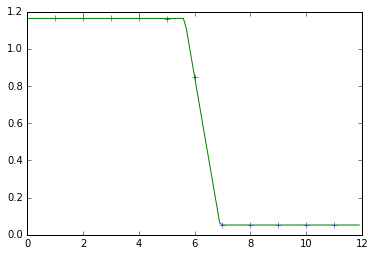

In [26]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Keep only the frames for which the excitation is on and save

In [27]:
D4=np.transpose(data[:,:,:,range(ONint,(OFFint+1))],(2,1,0,3))
nim=nib.Nifti1Image(D4,np.eye(4))
nib.save(nim,'/home/sophie/Desktop/'+Dataname+'on.nii.gz')

# Get times corresponding to images (exctiation light completely on : t=0)

In [44]:
TimeFile='/home/sophie/Downloads/Data'+''.join([Dataname[i] for i in range(3)])+'_.csv'

In [45]:
print(TimeFile)

/home/sophie/Downloads/Data816_.csv


In [46]:
Listfile = open(TimeFile, 'r')
ListTime = [line.split('\n')[0] for line in Listfile.readlines()]

IOError: [Errno 2] No such file or directory: '/home/sophie/Downloads/Data816_.csv'

In [ ]:
Timespl=[float(ListTime[i].split(',')[2]) for i in range(1,len(ListTime))]

In [ ]:
plt.plot(Timespl)

In [ ]:
max(Timespl)

In [ ]:
TimeOn=[Timespl[i] for i in range(ONint+382,(OFFint+1+382))]

In [ ]:
Tinit=(ON-ONint-1)*(Timespl[ONint+382]-Timespl[ONint+382-1])+Timespl[ONint+382-1]

In [ ]:
Tinit

In [ ]:
TimeOnFinal=TimeOn-Tinit

In [ ]:
D4.shape

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TimeFluoOn.mat', {'TimeFluoOn':TimeOnFinal})